In [1]:
import robotic as ry
import time
import numpy as np
def find_rrt_path(C, start_joint, goal_joint):
    print(f"Running RRT from {start_joint} to {goal_joint}...")
    ry.params_clear()
    ry.params_add({'rrt/stepsize':.1, 'rrt/verbose': 0,'rrt/maxIters':15000}) #verbose=3 makes it very slow, and displays result, and verbose=4 waits keypress..
    rrt_solver = ry.PathFinder()
    rrt_solver.setProblem(C, [start_joint], [goal_joint])  
    result = rrt_solver.solve()
    if result is not None and result.x is not None:
        print("Feasible path found!")
        return result 
    else:
        print("No feasible path found.")
        return None


NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 112 of `/tmp/ipykernel_1333/559042396.py`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Philip Stahl, Jan Wülfing)
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

Plan found:
pick(tray1, table1, l_gripper)
place(tray1, bin, l_gripper)
allow_next_pick(mug)
pick(mug, table1, l_gripper)
allow_next_pick(tray2)
place(mug, bin, l_gripper)
pick(tray2, table1, l_gripper)
place(tray2, bin, l_gripper)
allow_wiping
wipe(table1, l_gripper)


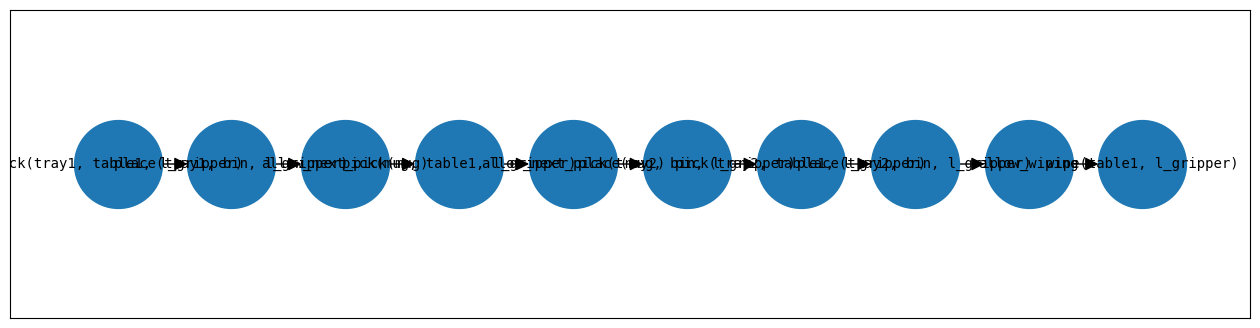

In [3]:
from unified_planning.shortcuts import *
from unified_planning.plot import plot_sequential_plan

# Define User Types
Location = UserType("Location")
Object = UserType("Object")
Tool = UserType("Tool")


# Define Objects
tray1 = unified_planning.model.Object("tray1", Object)
tray2 = unified_planning.model.Object("tray2", Object)
mug = unified_planning.model.Object("mug", Object)
sponge = unified_planning.model.Object("sponge", Tool)
l_gripper = unified_planning.model.Object("l_gripper", Tool)
table1 = unified_planning.model.Object("table1", Location)
bin = unified_planning.model.Object("bin", Location)
dustbin = unified_planning.model.Object("dustbin", Location)


# Define Fluents
on = Fluent("on", BoolType(), obj=Object, loc=Location)
holding = Fluent("holding", BoolType(), tool=Tool)
ready_to_pick = Fluent("ready_to_pick", BoolType(), obj=Object)
needs_processing = Fluent("needs_processing", BoolType(), obj=Object)  
dirty = Fluent("dirty", BoolType(), loc=Location)
clean = Fluent("clean", BoolType(), loc=Location)
wiping_allowed = Fluent("wiping_allowed", BoolType())
usable_tool = Fluent("usable_tool", BoolType(), obj=Object, tool=Tool)

# Define Actions
pick = InstantaneousAction("pick", obj=Object, loc=Location, tool=Tool)
pick_obj, pick_loc, pick_tool = pick.parameters
pick.add_precondition(on(pick_obj, pick_loc))  
pick.add_precondition(ready_to_pick(pick_obj)) 
pick.add_precondition(usable_tool(pick_obj, pick_tool)) 
pick.add_precondition(needs_processing(pick_obj))  
pick.add_effect(on(pick_obj, pick_loc), False)  
pick.add_effect(holding(pick_tool), True)  

place = InstantaneousAction("place", obj=Object, loc=Location, tool=Tool)
place_obj, place_loc, place_tool = place.parameters
place.add_precondition(holding(place_tool))  
place.add_precondition(needs_processing(place_obj))  
place.add_effect(holding(place_tool), False)  
place.add_effect(on(place_obj, place_loc), True)  
place.add_effect(needs_processing(place_obj), False)  

allow_next_pick = InstantaneousAction("allow_next_pick", obj=Object)
allow_next_pick_obj = allow_next_pick.parameter("obj")
allow_next_pick.add_precondition(needs_processing(allow_next_pick_obj))  
allow_next_pick.add_precondition(on(tray1, bin))  
allow_next_pick.add_effect(ready_to_pick(allow_next_pick_obj), True)  

allow_wiping = InstantaneousAction("allow_wiping")
allow_wiping.add_precondition(on(tray1, bin))
allow_wiping.add_precondition(on(tray2, bin))
allow_wiping.add_precondition(on(mug, bin))
allow_wiping.add_effect(wiping_allowed, True)  

wipe = InstantaneousAction("wipe", loc=Location, tool=Tool)
wipe_loc, wipe_tool = wipe.parameters
wipe.add_precondition(dirty(wipe_loc))  
wipe.add_precondition(wiping_allowed)  
wipe.add_effect(dirty(wipe_loc), False)  
wipe.add_effect(clean(wipe_loc), True)  

# Define Problem
problem = Problem("table_cleaning")
problem.add_fluent(on, default_initial_value=False)
problem.add_fluent(holding, default_initial_value=False)
problem.add_fluent(ready_to_pick, default_initial_value=False)
problem.add_fluent(needs_processing, default_initial_value=False)
problem.add_fluent(dirty, default_initial_value=False)
problem.add_fluent(clean, default_initial_value=False)
problem.add_fluent(wiping_allowed, default_initial_value=False)
problem.add_fluent(usable_tool, default_initial_value=False)

problem.add_action(pick)
problem.add_action(place)
problem.add_action(allow_next_pick)
problem.add_action(allow_wiping)
problem.add_action(wipe)

problem.add_objects([tray1, tray2, mug, sponge, l_gripper, table1, bin, dustbin])

# Define Initial State
problem.set_initial_value(on(tray1, table1), True)
problem.set_initial_value(on(tray2, table1), True)
problem.set_initial_value(on(mug, table1), True)
problem.set_initial_value(dirty(table1), True)
problem.set_initial_value(holding(l_gripper), False)
problem.set_initial_value(holding(sponge), False)
problem.set_initial_value(wiping_allowed, False)
problem.set_initial_value(ready_to_pick(tray1), True)  
problem.set_initial_value(needs_processing(tray1), True)
problem.set_initial_value(needs_processing(tray2), True)
problem.set_initial_value(needs_processing(mug), True)

# Tool Constraints
problem.set_initial_value(usable_tool(tray1, l_gripper), True)
problem.set_initial_value(usable_tool(tray2, l_gripper), True)
problem.set_initial_value(usable_tool(mug, l_gripper), True)

# Define Goals
problem.add_goal(on(tray1, bin))
problem.add_goal(on(tray2, bin))
problem.add_goal(on(mug, bin))
problem.add_goal(clean(table1))

# Solve the Problem
with OneshotPlanner(name="pyperplan") as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Plan found:")
        for action in result.plan.actions:
            print(action)
        plan = result.plan
        if plan is not None:
            plot_sequential_plan(plan, figsize=(16, 4), node_size=4000, font_size=10)
    else:
        print("No plan found.")


In [5]:
if plan: 
    C = ry.Config()
    C.addFile(ry.raiPath('../rai-robotModels/task.g'))  

    for action_instance in plan.actions:
        action_name = action_instance.action.name
        parameters = action_instance.actual_parameters

        if action_name == "pick":
            obj, loc, tool = [str(p.object()) for p in parameters]
            if loc == "table1":  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                obj_frame = C.frame(obj)
                goal_position = obj_frame.getPosition()
                IK_goal = tool_frame.setPosition(goal_position)
                goal_joint = C.getJointState()  
                C.view()
                print(f"Executing 'pick': Moving tool '{tool}' to pick object '{obj}' from '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)
        elif action_name == "place":
            obj, loc, tool = [str(p.object()) for p in parameters]
            if loc in ["bin1", "dustbin"]:  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                loc_frame = C.frame(loc)
                goal_position = loc_frame.getPosition()
                IK_goal = tool_frame.setPosition(goal_position)
                goal_joint = C.getJointState()  

                print(f"Executing 'place': Moving tool '{tool}' to place object '{obj}' at '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)

        elif action_name == "wipe":
            loc, tool = [str(p.object()) for p in parameters]
            if loc == "table1":  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                goal_position = loc_frame.getPosition()
                IK_goal = tool_frame.setPosition(goal_position)
                goal_joint = C.getJointState()  

                print(f"Executing 'wipe': Moving tool '{tool}' to wipe location '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)

        elif action_name == "allow_wiping":
            print("Executing 'allow_wiping': Logical action to enable wiping. No physical movement required.")
            time.sleep(1)  


Executing 'pick': Moving tool 'l_gripper' to pick object 'tray1' from 'table1'
Running RRT from [array([ 0. , -0.5,  0. , -2. ,  0. ,  2. , -0.5])] to [array([ 0. , -0.5,  0. , -2. ,  0. ,  2. , -0.5])]...
Feasible path found!
position:  [ 0.  -0.5  0.  -2.   0.   2.  -0.5]
entered RRT_Star_PathFinder
entered getPathFromNode
parent[0, 0, 1] fromID 1
path append[0.0091869, -0.464431, 0.0395134, -1.9521, -0.0401482, 1.97694, -0.551484]node1
path append[0, -0.5, 0, -2, 0, 2, -0.5]node0
entered getPathFromNode
parent[0, 0] fromID 1
path append[-0.0356767, -0.456863, -0.0428931, -1.98218, -0.0444975, 1.98959, -0.551193]node1
path append[0, -0.5, 0, -2, 0, 2, -0.5]node0
normal solve completed!
-- WARNING:RenderData.cpp:glInitialize:105(-1) FreeType Error: Failed to load font 'ubuntu/Ubuntu-L.ttf' error code: 1 -> text rendering disabled
position:  [ 0.0091869  -0.46443076  0.03951343 -1.95209567 -0.04014821  1.9769393
 -0.55148417]
position:  [-0.03567665 -0.45686342 -0.04289312 -1.98218297 